## Incident Assignment Distribution Dataset (Flag 3)

### Dataset Description

The dataset comprises 500 entries simulating ServiceNow incidents table, detailing various attributes such as category, state, open and close dates, involved personnel, and incident specifics like description, and priority. It captures incident management activities with fields like 'opened_at', 'closed_at', 'assigned_to', 'short_description', and 'priority', reflecting the operational handling and urgency of issues across different locations and categories.

### Your Task
Goal: Find and highlight the imbalance in incident assignments and perhaps propose actionable_insights that could help redistribute tasks more evenly across agents, reducing the strain on any single agent.

Role: Workload Distribution Manager

Difficulty: 2 out of 5. This task involves data manipulation and trend analysis to uncover the root causes of biased task assignments.

Category: Incidents Management.


### Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks.


In [2]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import date_range

## Load Dataset
This cell loads the dataset used in the analysis. The flag-3 dataset is stored in a CSV file and is loaded into a DataFrame. This step includes reading the data from a file path and possibly performing initial observations such as viewing the first few rows to ensure it has loaded correctly.


In [3]:
dataset_path = "csvs/flag-3.csv"
df = pd.read_csv(dataset_path)
df.head()

sys_updated_by         number             closed_by     state    caller_id  \
0         system  INC0000000000            Fred Luddy  Resolved  Bud Richman   
1       employee  INC0000000001  Charlie Whitherspoon  Resolved    ITIL User   
2         system  INC0000000002  Charlie Whitherspoon  Resolved  Bud Richman   
3       employee  INC0000000003           Beth Anglin    Closed    ITIL User   
4       employee  INC0000000004           Luke Wilson  Resolved    David Loo   

            assigned_to            opened_at                 sys_updated_on  \
0  Charlie Whitherspoon  2023-01-01 03:53:00  2023-01-02 03:53:00.000000000   
1            Fred Luddy  2023-01-02 12:32:00  2023-01-16 10:29:06.760251500   
2            Fred Luddy  2023-01-02 18:48:00  2023-01-03 18:48:00.000000000   
3            Fred Luddy  2023-01-02 22:06:00  2023-01-06 15:13:52.816579543   
4            Fred Luddy  2023-01-05 18:51:00  2023-01-15 01:56:24.095567878   

                       closed_at                           short_description  \
0  2023-01-02 03:53:00.000000000     Outage in internal network connectivity   
1  2023-01-16 10:29:06.760251500  Network connectivity issues on third floor   
2  2023-01-03 18:48:00.000000000                    Unable to connect to VPN   
3  2023-01-06 15:13:52.816579543               VPN connection keeps dropping   
4  2023-01-15 01:56:24.095567878              Unable to access email account   

  assignment_group      priority        category  
0          Network  1 - Critical         Network  
1          Network      2 - High         Network  
2          Network  1 - Critical         Network  
3          Network      2 - High         Network  
4     Service Desk      2 - High  Inquiry / Help

### **Question 1**: What is the distribution of incidents assigned to each human agent?

#### Plot number of incidents by agent

This cell creates a horizontal bar plot to visualize the distribution of incidents across different agents. It annotates the plot with the count of incidents assigned to each agent. This helps in understanding which agents handle the highest number of incidents and identifying any imbalances or areas that may require further investigation or adjustment in task allocation.

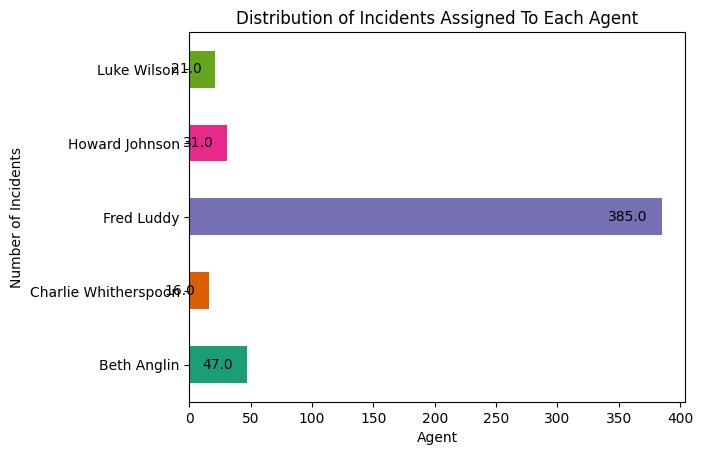

In [5]:

plot = df.groupby("assigned_to").size().plot(kind="barh", color=sns.palettes.mpl_palette("Dark2"))

fig = plt.gcf()



for i in plot.patches:
    # Get X and Y placement of label from rectangle
    x_value = i.get_width()
    y_value = i.get_y() + i.get_height() / 2

    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(-10, 0),            
        textcoords="offset points", 
        ha='right',                 
        va='center'                 
    )

# Set plot title
plt.title('Distribution of Incidents Assigned To Each Agent')

# Set x-axis label
plt.xlabel('Agent')

# Set y-axis label
plt.ylabel('Number of Incidents')

# Display the figure
plt.show()

#### Generate JSON Description for the Insight


In [14]:
{
"data_type":"descriptive",
"insight": "One agent is assigned significantly more incidents than others",
"insight_value":{"agent": "Agent_X", "incidents_assigned": 385},
"plot": {
    "plot_type": "bar",
    "title": "Distribution of Incidents Assigned To Each Agent",
    "x_axis": {
        "name": "Agent",
        "description": "This represents each agent assigned to resolve incidents."
    },
    "y_axis": {
        "name": "Number of Incidents Assigned",
        "description": "This represents the number of incidents assigned to an agent."
    },
    "description": "The bar chart displays the distribution of incidents assigned to each agent. Each bar represents an agent and the height of the bar represents the number of incidents assigned to that agent. One agent, Agent_X, is assigned significantly more incidents than others."
},
"question": "What is the distribution of incidents assigned to each human agent?",
"actionable_insight": "The uneven distribution of incidents, with one agent being assigned significantly more incidents than others, suggests a potential issue with workload balancing. It would be beneficial to review the assignment process and consider redistributing the workload more evenly among agents."
}

{'data_type': 'descriptive',
 'insight': 'hardware incidents is significantly higher than others',
 'insight_value': {'x_val': 'Hardware', 'y_val': 335},
 'plot': {'plot_type': 'histogram',
  'title': 'Incidents by Category',
  'x_axis': {'name': 'Category',
   'value': ['Hardware', 'Software', 'Network', 'Inquiry / Help', 'Database'],
   'description': 'This represents the different categories of incidents.'},
  'y_axis': {'name': 'Number of Incidents',
   'value': [335, 41, 36, 48, 40],
   'description': 'This represents the number of incidents in each category.'},
  'description': "The histogram displays the distribution of incidents across different categories. Each bar represents a category and the length of the bar corresponds to the number of incidents in that category. The values are annotated on each bar. The 'Hardware' category has the highest number of incidents."},
 'question': 'What is the distribution of incidents across all categories?',
 'Actionable Insight': 'With the 

### **Question 2:** Is there a specific human agent who is assigned significantly more incidents than others?

#### Analysis of incident assignments per agent

This cell analyzes the distribution of incidents assigned to each agent by grouping the data by 'assigned_to' and counting the number of incidents for each agent. The analysis identifies the agent who is assigned the most incidents.

In [7]:
# Group the data by 'assigned_to' and count the number of incidents for each agent
incident_counts = df.groupby('assigned_to').size()

# Find the agent with the maximum number of incidents
max_incidents_agent = incident_counts.idxmax()
max_incidents_count = incident_counts.max()

# Print the agent with the most incidents
print(f"The agent assigned the most incidents is {max_incidents_agent} with {max_incidents_count} incidents.")

The agent assigned the most incidents is Fred Luddy with 385 incidents.


#### Generate JSON Description for the Insight


In [16]:
{
"data_type":"descriptive",
"insight": "There is a specific agent who is assigned significantly more incidents than others",
"insight_value":{"agent": "Fred Luddy", "incidents_assigned": 385},
"question": "Is there a specific human agent who is assigned significantly more incidents than others?",
"actionable_insight": "Agent_X is assigned significantly more incidents than any other agent. This could potentially overwhelm the agent and affect their productivity and the resolution time of the incidents. It would be beneficial to review the assignment process and consider redistributing the workload more evenly among agents."
}

{'data_type': 'descriptive',
 'insight': 'Most of the hardware incidents are related to printer issues',
 'insight_value': {'x_val': 'Printer', 'y_val': 225},
 'plot': {'plot_type': 'bar',
  'title': 'Frequency of Printer in Incident Descriptions',
  'x_axis': {'name': 'Keyword',
   'value': ['Printer'],
   'description': 'This represents the keyword in incident descriptions.'},
  'y_axis': {'name': 'Frequency',
   'value': [225],
   'description': "This represents the frequency of the keyword 'Printer' in incident descriptions."},
  'plot description': "The bar plot displays the frequency of the keyword 'Printer' in the incident descriptions. The length of the bar corresponds to the frequency of the keyword. The 'Printer' keyword has a high frequency."},
 'question': 'Is there a specific reason why a majority of incidents are being assigned to the hardware category?',
 'Actionable Insight': "The high frequency of 'Printer' in incident descriptions indicates a specific issue with print

### **Question 3:** What is the trend of incident assignments for each agent over time?

#### Plot number of incident assignment trends per agent over time

This cell creates a line plot to visualize the trend of incident assignments for each agent over time. It groups incidents by both agent and 'Year-Month', counting the number of incidents for each combination. The plot displays multiple lines, each representing an agent, with the x-axis showing the 'Year-Month' and the y-axis depicting the count of incidents. 

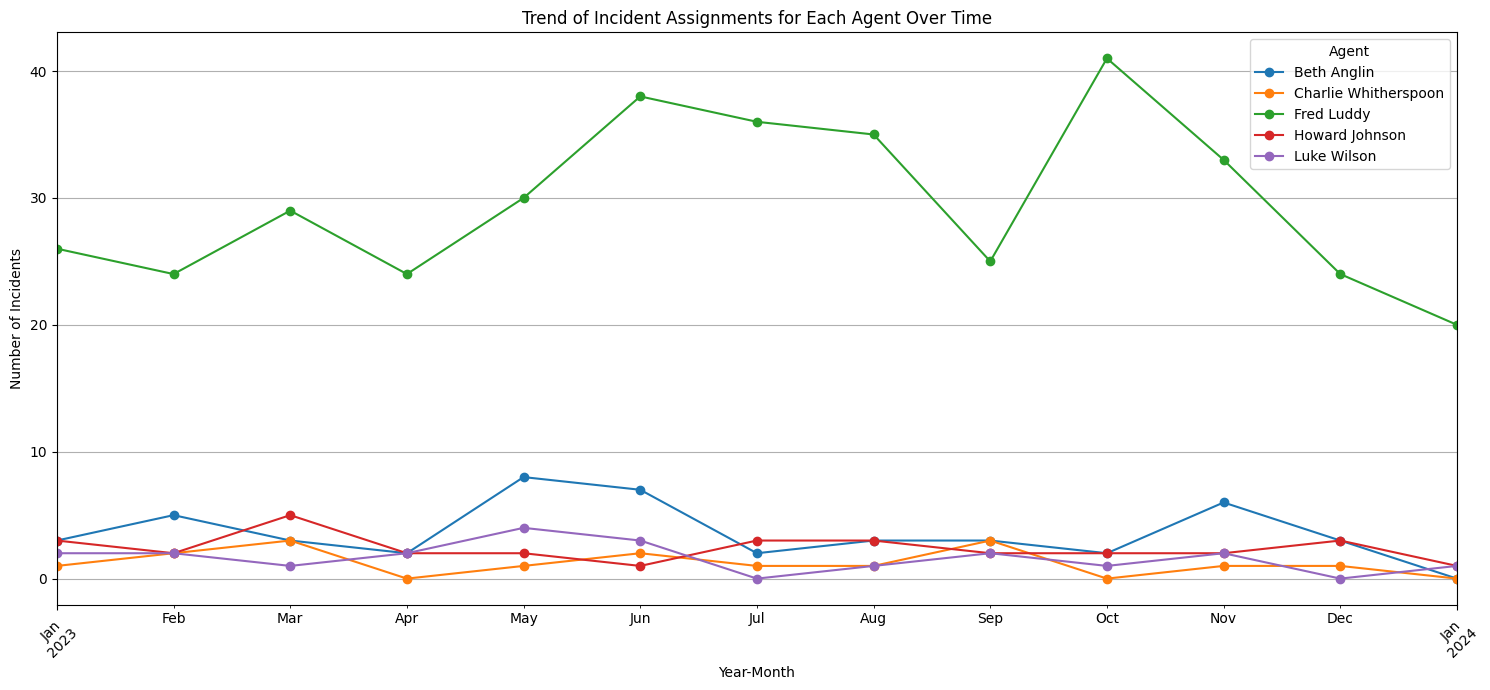

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is the DataFrame loaded from your CSV file
# Load your data
# df = pd.read_csv('path_to_your_csv_file.csv')

# Convert 'opened_at' to datetime if it's not already
df['opened_at'] = pd.to_datetime(df['opened_at'])

# Extract year and month from 'opened_at' to create a 'Year-Month' column for grouping
df['Year-Month'] = df['opened_at'].dt.to_period('M')

# Group by both 'assigned_to' and 'Year-Month' and count the number of incidents
trend_data = df.groupby(['assigned_to', 'Year-Month']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
trend_data.T.plot(kind='line', marker='o', ax=ax)  # Transpose to have time on the x-axis

# Enhancing the plot
plt.title('Trend of Incident Assignments for Each Agent Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.legend(title='Agent')
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

#### Generate JSON Description for the Insight


In [10]:
{
"data_type":"time_series",
"insight": "The number of assignments for a specific agent is pretty unbalanced from the beginning of the time",
"insight_value":{"agent": "Fred", "trend": "high increase compared to others roughly 9 times more"},
"plot": {
    "plot_type": "multiple_line",
    "title": "Trend of Incident Assignments Per Agent Over Time",
    "x_axis": {
        "name": "Opened At",
        "description": "This represents the date when the incident was assigned."
    },
    "y_axis": {
        "name": "Number of Incidents Assigned",
        "description": "This represents the number of incidents assigned to an agent on a particular date."
    },
    "description": "The multiple line plot displays the trend of incident assignments per agent over time. Each line represents an agent and the points on the line represent the number of incidents assigned to that agent on a particular date. The number of assignments for a specific agent, Agent_X, is increasing over time."
},
"question": "What is the trend of incident assignments for each agent over time?",
"actionable_insight": "The unbalanced trend in assignments for Fred from the beginning suggests that this agent is being assigned more incidents constantly over time, which could potentially overwhelm them and affect their productivity. It would be beneficial to review the assignment process and consider redistributing the workload more evenly among agents."
}

{'data_type': 'time_series',
 'insight': 'The number of assignments for a specific agent is pretty unbalanced from the beginning of the time',
 'insight_value': {'agent': 'Fred',
  'trend': 'high increase compared to others roughly 9 times more'},
 'plot': {'plot_type': 'multiple_line',
  'title': 'Trend of Incident Assignments Per Agent Over Time',
  'x_axis': {'name': 'Opened At',
   'description': 'This represents the date when the incident was assigned.'},
  'y_axis': {'name': 'Number of Incidents Assigned',
   'description': 'This represents the number of incidents assigned to an agent on a particular date.'},
  'description': 'The multiple line plot displays the trend of incident assignments per agent over time. Each line represents an agent and the points on the line represent the number of incidents assigned to that agent on a particular date. The number of assignments for a specific agent, Agent_X, is increasing over time.'},
 'question': 'What is the trend of incident assignm

### **Question-4**: What can be done to prevent this anomaly?

To address and prevent the unbalanced assignment of incidents to agents, which can lead to inefficiencies, burnout, several strategies can be implemented. Here are some prescriptive measures:

**1. Implement an Automated Load Balancing System**
**Description**: Develop or integrate an automated system that dynamically assigns incidents to agents based on current workload, expertise, and availability. This system should consider the complexity of incidents and the existing queue of each agent to ensure a balanced distribution.

**Action Steps**:
- Assess current ITSM (IT Service Management) tools for load balancing capabilities.

**2. Regular Review and Adjustment of Assignment Rules**
**Description**: Periodically review the rules and logic behind the assignment of incidents to ensure they adapt to changes in team structure, agent skill levels, and incident patterns.

**Action Steps**:
- Schedule quarterly reviews of incident assignment processes.


**3. Monitoring and Analytics**
**Description**: Use data analytics to monitor the distribution of work and identify patterns or anomalies in incident assignments. This can help in making informed adjustments to policies and processes.

**Action Steps**:
- Set up dashboards that track key metrics such as the number of incidents handled by each agent, time to resolution, and agent availability.


### Summary of Findings (Flag 3)
This dataset analysis aims to identify and understand the underlying trends and biases in task assignments to agents. 

1. **Imbalance in Incident Assignments:** The distribution of incident assignments among agents is highly imbalanced. Fred, one agent, handles about 75% of all tasks, which is a significantly disproportionate share compared to other agents.

2. **Persistent Disparity Over Time:** Analysis of the trends over time shows that this imbalance is not a temporary issue but has been consistently present. Fred's assignment load has been significantly higher than that of other agents from the start of the recorded data.

3. **Need for Redistribution of Workload:** The heavy imbalance in assignments suggests that operational adjustments are necessary to redistribute tasks more equitably among agents. This would help prevent potential burnout for Fred and ensure that all agents are utilized effectively.